# Data visualization and EDA for CryoET project

Adapted some code from these notebooks:
* https://www.kaggle.com/code/davidlist/full-catalog-of-labeled-particles
* https://www.kaggle.com/code/rmsbms/eda-particles-visualization
* https://www.kaggle.com/code/davidlist/experiment-ts-6-4-visualization/notebook

In [3]:
!pip install zarr
!pip install -q ome-zarr
!pip install -q copick

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 4.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 72.7 MB/s eta 0:00:00:00:0100:01
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=ba7be24566f0181b8a65f426df3481e418ba57c54f77d56e16e76c0a4fd295c1
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 707.0/707.0 kB 12.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 4.2 MB/s eta 0:00:00


In [4]:
#IMPORTS
import json
import numpy as np
import zarr
import random
import os

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

pio.renderers.default = 'iframe'

In [5]:
#CONSTANTS
TRAIN_BASE = '/kaggle/input/czii-cryo-et-object-identification/train/static/ExperimentRuns'
TEST_BASE = '/kaggle/input/czii-cryo-et-object-identification/test/static/ExperimentRuns'
OVERLAY_BASE = '/kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns'
TRAINING_SETS = ['TS_86_3', 'TS_6_6', 'TS_73_6', 'TS_99_9', 'TS_69_2', 'TS_6_4', 'TS_5_4']
PARTICLE_RADIUS = {
    'apo-ferritin': 60.0,
    'beta-amylase': 65.0,
    'beta-galactosidase': 90.0,
    'ribosome': 150.0,
    'thyroglobulin': 130.0,
    'virus-like-particle': 135.0,
}

In [6]:
#FUNCTIONS
def get_experiment_path(experiment, type='denoised', test=False):
    base = TEST_BASE if test else TRAIN_BASE
    return base + '/' + experiment + '/VoxelSpacing10.000/' + type + '.zarr'

def open_experiment(experiment, test=False):
    return zarr.open(get_experiment_path(experiment, test=test), mode='r')

def load_points(experiment, particle='ribosome'):
    results = []
    path = OVERLAY_BASE + '/' + experiment + '/Picks/' + particle + '.json'
    with open(path) as f:
        points = json.loads(f.read())['points']
        for p in points:
            x = float(p['location']['x'])
            y = float(p['location']['y'])
            z = float(p['location']['z'])
            results.append((x, y, z))
    return results

def normalize(dataset):
    return (dataset - np.mean(dataset))/np.std(dataset)

# Example loading and processing data

In [7]:
#define path to zarr file of interest
zarr_path = os.path.join(TRAIN_BASE,'TS_5_4/VoxelSpacing10.000/wbp.zarr')

# Open the zarr array
zarr_store = zarr.open(str(zarr_path))

#0, 1, and 2 represent different resolutions of the same underlying data
print(zarr_store.tree())

/
 ├── 0 (184, 630, 630) float32
 ├── 1 (92, 315, 315) float32
 └── 2 (46, 158, 158) float32


In [8]:
# Get the highest resolution data (scale 0)
my_tomogram = zarr_store['0'][:]

print(f"Tomogram shape: {my_tomogram.shape}")
print(f"Min value: {my_tomogram.min()}")
print(f"Max value: {my_tomogram.max()}")
print(f"Mean value: {my_tomogram.mean()}")

Tomogram shape: (184, 630, 630)
Min value: -0.0010549420258030295
Max value: 0.0009750329190865159
Mean value: 2.514233301553759e-07


In [9]:
#explore the JSON file structure for an example protein
json_path = os.path.join(OVERLAY_BASE,'TS_5_4/Picks/apo-ferritin.json')

with open(json_path, 'r') as f:
    my_data = json.load(f)

#keys:
my_data.keys()

dict_keys(['pickable_object_name', 'user_id', 'session_id', 'run_name', 'voxel_spacing', 'unit', 'points', 'trust_orientation'])

In [10]:
#look at some entries in "points" - I believe these represent annotated apo-ferritin locations
my_data['points'][:3]

[{'location': {'x': 468.514, 'y': 5915.906, 'z': 604.167},
  'transformation_': [[1.0, 0.0, 0.0, 0.0],
   [0.0, 1.0, 0.0, 0.0],
   [0.0, 0.0, 1.0, 0.0],
   [0.0, 0.0, 0.0, 1.0]],
  'instance_id': 0},
 {'location': {'x': 5674.694, 'y': 1114.354, 'z': 565.068},
  'transformation_': [[1.0, 0.0, 0.0, 0.0],
   [0.0, 1.0, 0.0, 0.0],
   [0.0, 0.0, 1.0, 0.0],
   [0.0, 0.0, 0.0, 1.0]],
  'instance_id': 0},
 {'location': {'x': 5744.509, 'y': 1049.172, 'z': 653.712},
  'transformation_': [[1.0, 0.0, 0.0, 0.0],
   [0.0, 1.0, 0.0, 0.0],
   [0.0, 0.0, 1.0, 0.0],
   [0.0, 0.0, 0.0, 1.0]],
  'instance_id': 0}]

In [11]:
#extract and format the coordinates from "points"
def format_coords(data):
    coords = []
    for point in data['points']:
        coords.append([
            point['location']['z'],
            point['location']['y'],
            point['location']['x']
        ])
    
    coords = np.array(coords)
    return(coords)

af_coords = format_coords(my_data)
len(af_coords)

46

In [12]:
# Print some basic statistics
print("\nCoordinate ranges:")
print(f"Z range: {af_coords[:, 0].min():.1f} to {af_coords[:, 0].max():.1f}")
print(f"Y range: {af_coords[:, 1].min():.1f} to {af_coords[:, 1].max():.1f}")
print(f"X range: {af_coords[:, 2].min():.1f} to {af_coords[:, 2].max():.1f}")


Coordinate ranges:
Z range: 76.3 to 1296.6
Y range: 1049.2 to 5915.9
X range: 468.5 to 5880.8


In [13]:
#coordinates should be scaled prior to plotting
def scale_coordinates(coords, tomogram_shape):
    """Scale coordinates to match tomogram dimensions."""
    scaled_coords = coords.copy()
    
    # Scale factors for each dimension
    scale_z = tomogram_shape[0] / coords[:, 0].max()
    scale_y = tomogram_shape[1] / coords[:, 1].max()
    scale_x = tomogram_shape[2] / coords[:, 2].max()
    
    # Apply scaling
    scaled_coords[:, 0] = coords[:, 0] * scale_z
    scaled_coords[:, 1] = coords[:, 1] * scale_y
    scaled_coords[:, 2] = coords[:, 2] * scale_x
    
    return scaled_coords


scaled_af_coords = scale_coordinates(af_coords, my_tomogram.shape)

print("\nCoordinate ranges after scaling:")
print(f"Z range: {scaled_af_coords[:, 0].min():.1f} to {scaled_af_coords[:, 0].max():.1f}")
print(f"Y range: {scaled_af_coords[:, 1].min():.1f} to {scaled_af_coords[:, 1].max():.1f}")
print(f"X range: {scaled_af_coords[:, 2].min():.1f} to {scaled_af_coords[:, 2].max():.1f}")


Coordinate ranges after scaling:
Z range: 10.8 to 184.0
Y range: 111.7 to 630.0
X range: 50.2 to 630.0


# Plot example tomogram sections for each particle

In [196]:
def plot_particles(experiment, particle, n_show=9, seed=1337):
    random.seed(seed)
    
    dataset = normalize(open_experiment(experiment)[0])
    particles = load_points(experiment, particle=particle)
    p_subset = sorted(random.sample(particles,n_show), key=lambda p: p[2])
    
    plt.figure(figsize=(10, 3.5*(len(p_subset)//3 + 1)))
    for idx in range(len(p_subset)):
        i = int(np.rint(p_subset[idx][0]/10.012))
        j = int(np.rint(p_subset[idx][1]/10.012))
        k = int(np.rint(p_subset[idx][2]/10.012))

        # Fix display problem near the edges.
        i_min = i - 24 if i - 24 > 0 else 0
        j_min = j - 24 if j - 24 > 0 else 0
        
        plt.subplot(len(p_subset)//3 + 1, 3, idx + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(str(idx) + ': ' + str((k,j,i,)))
        plt.imshow(dataset[k, (j_min):(j+25), (i_min):(i+25)], cmap='gray')

In [ ]:
z_ts_6_4 = zarr.open('/kaggle/input/czii-cryo-et-object-identification/test/static/ExperimentRuns/TS_6_4/VoxelSpacing10.000/denoised.zarr', mode='r')

## Apo-Ferritin

![](https://www.ebi.ac.uk/pdbe/emdb-empiar/entryIcons//10263-l.gif)

Image from the following source:  
[https://www.ebi.ac.uk/empiar/EMPIAR-10263/](https://www.ebi.ac.uk/empiar/EMPIAR-10263/)  
This is the actual particle for the competition:  
[https://www.rcsb.org/structure/4V1W](https://www.rcsb.org/structure/4V1W)

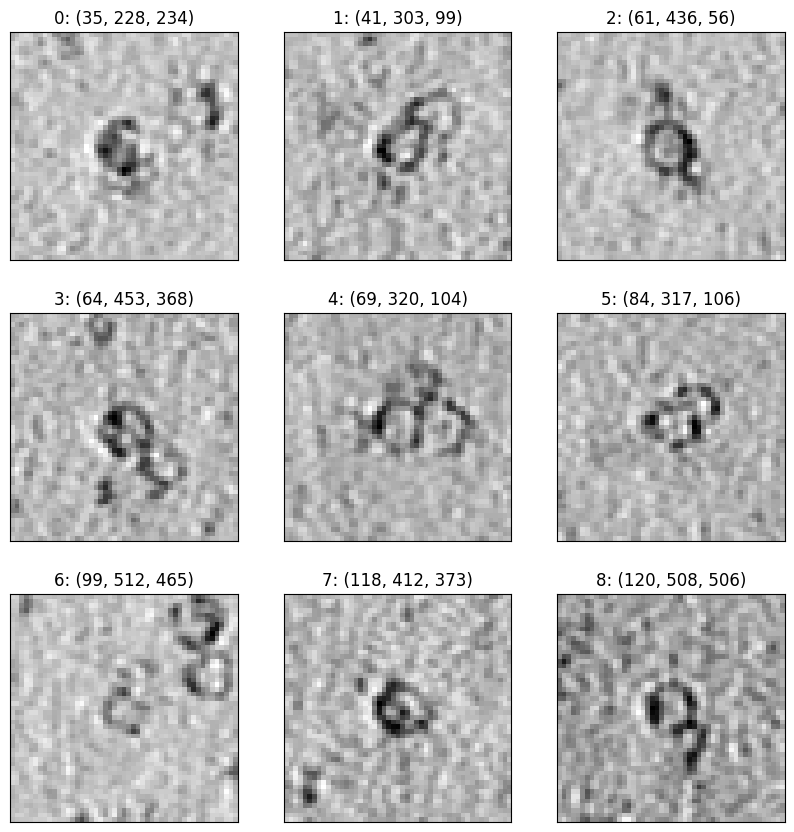

In [197]:
plot_particles('TS_5_4', 'apo-ferritin',n_show=9)

In [49]:
apo_ferritin_x = []
apo_ferritin_y = []
f = open('/kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_6_4/Picks/apo-ferritin.json')
for p in json.loads(f.read())['points']:
    z = float(p['location']['z'])
    if z >= 400 and z < 450:
        apo_ferritin_x.append(float(p['location']['x'])/10)
        apo_ferritin_y.append(float(p['location']['y'])/10)
        print(p['location'])

{'x': 1019.831, 'y': 1859.831, 'z': 400.424}
{'x': 3534.854, 'y': 2407.485, 'z': 425.439}
{'x': 3752.045, 'y': 2505.17, 'z': 411.989}
{'x': 3942.417, 'y': 2660.695, 'z': 413.609}
{'x': 4009.57, 'y': 2947.043, 'z': 412.634}
{'x': 4243.778, 'y': 2985.682, 'z': 420.398}
{'x': 3596.958, 'y': 2593.013, 'z': 415.516}
{'x': 3486.946, 'y': 2616.549, 'z': 415.516}
{'x': 3631.179, 'y': 2496.627, 'z': 415.516}


Text(0.5, 0.91, 'Annotated apo ferrotin in TS_6_4, for 400 < z < 450')

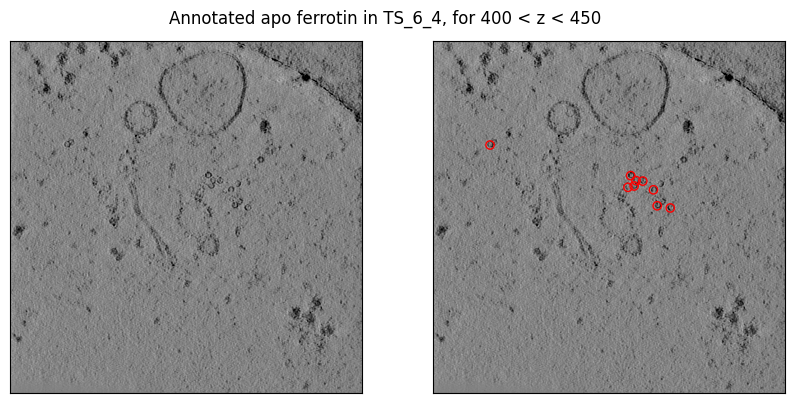

In [50]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(z_ts_6_4[0][42], cmap='gray', vmin=-0.00005, vmax=0.00005)
ax = plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(z_ts_6_4[0][42], cmap='gray', vmin=-0.00005, vmax=0.00005)
plt.scatter(apo_ferritin_x, apo_ferritin_y, edgecolor='red', facecolor='none')
plt.suptitle('Annotated apo ferrotin in TS_6_4, for 400 < z < 450',y=0.91)

## Beta-Amylase

![](https://cdn.rcsb.org/images/structures/1fa2_assembly-1.jpeg)  

Image from the following source:  
[https://www.rcsb.org/structure/1fa2](https://www.rcsb.org/structure/1fa2)

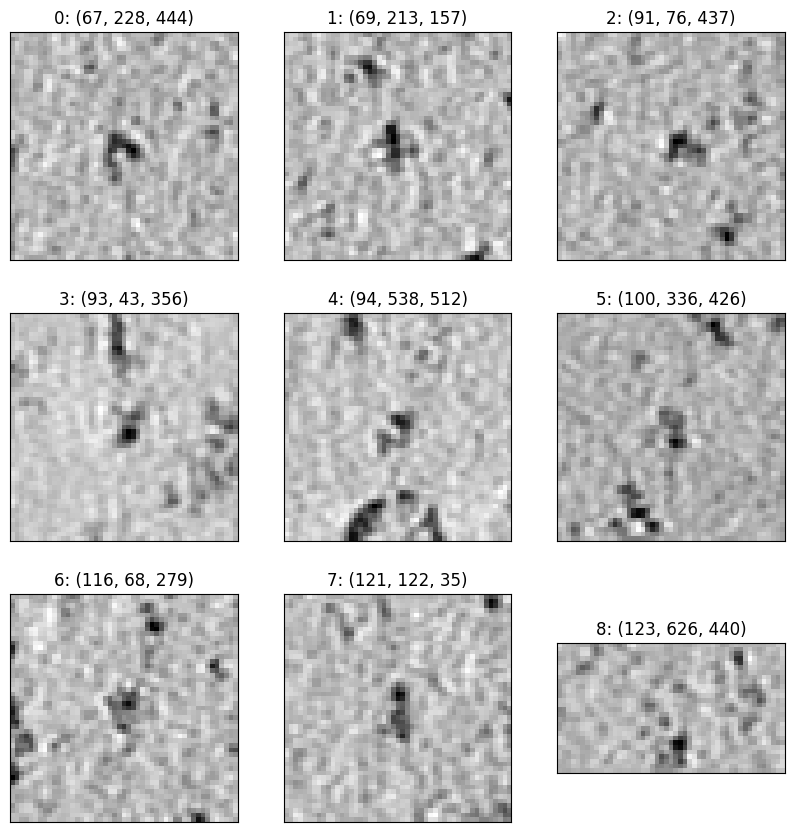

In [66]:
plot_particles('TS_69_2', 'beta-amylase',n_show=9)

## Beta-Galactosidase

![](https://cdn.rcsb.org/images/structures/6x1q_assembly-1.jpeg)

Image from this source:  
[https://www.rcsb.org/structure/6X1Q](https://www.rcsb.org/structure/6X1Q)

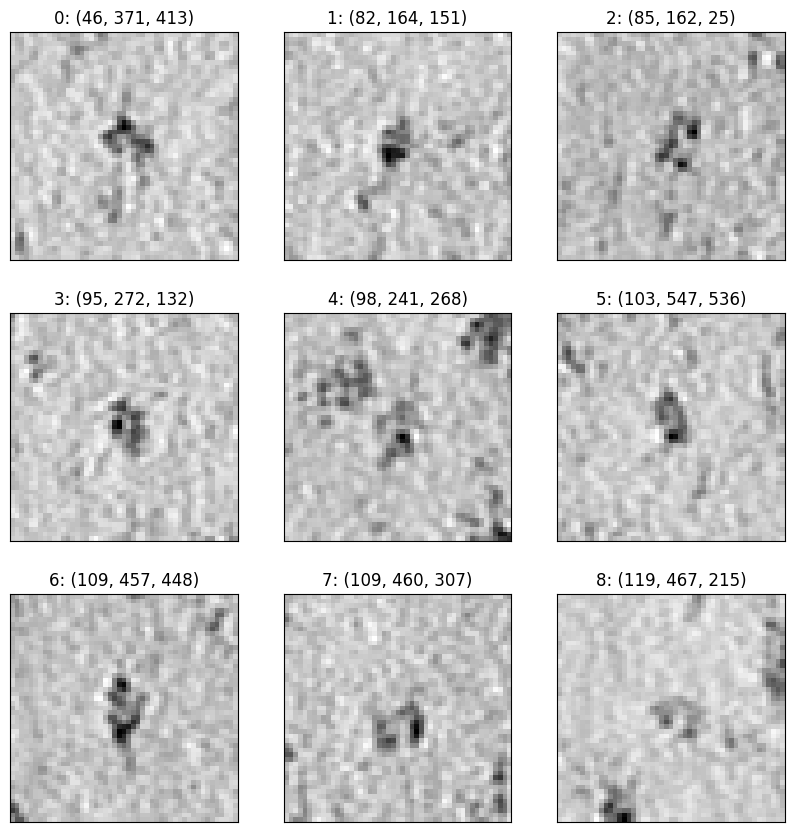

In [67]:
plot_particles('TS_6_4', 'beta-galactosidase',n_show=9)

In [62]:
beta_galactosidase_x = []
beta_galactosidase_y = []
f = open('/kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_6_4/Picks/beta-galactosidase.json')
for p in json.loads(f.read())['points']:
    z = float(p['location']['z'])
    if z >= 1030 and z < 1100:
        beta_galactosidase_x.append(float(p['location']['x'])/10)
        beta_galactosidase_y.append(float(p['location']['y'])/10)
        print(p['location'])

{'x': 5361.881, 'y': 5472.376, 'z': 1032.772}
{'x': 3072.5, 'y': 4610.0, 'z': 1090.0}
{'x': 4483.644, 'y': 4570.968, 'z': 1089.313}


Text(0.5, 0.91, 'Annotated beta galactosidase in TS_6_4, for 1030 < z < 1100')

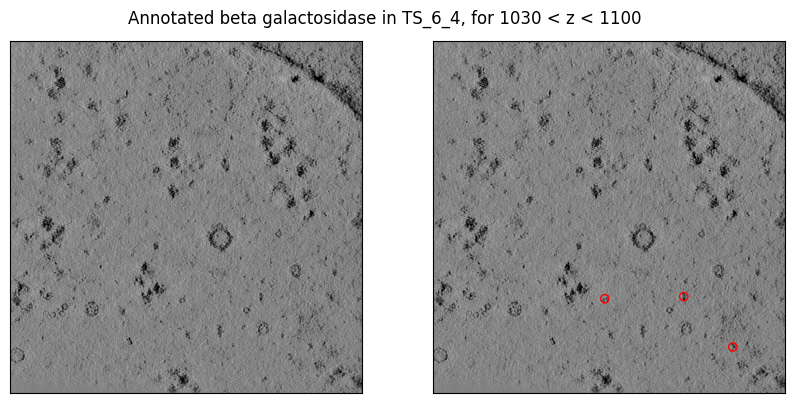

In [63]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(z_ts_6_4[0][106], cmap='gray', vmin=-0.00005, vmax=0.00005)
ax = plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(z_ts_6_4[0][106], cmap='gray', vmin=-0.00005, vmax=0.00005)
plt.scatter(beta_galactosidase_x, beta_galactosidase_y, edgecolor='red', facecolor='none')
plt.suptitle('Annotated beta galactosidase in TS_6_4, for 1030 < z < 1100',y=0.91)

## Ribosome

![](https://cdn.rcsb.org/images/structures/6qzp_assembly-1.jpeg)  

Image from this source:  
[https://www.rcsb.org/structure/6QZP](https://www.rcsb.org/structure/6QZP) 

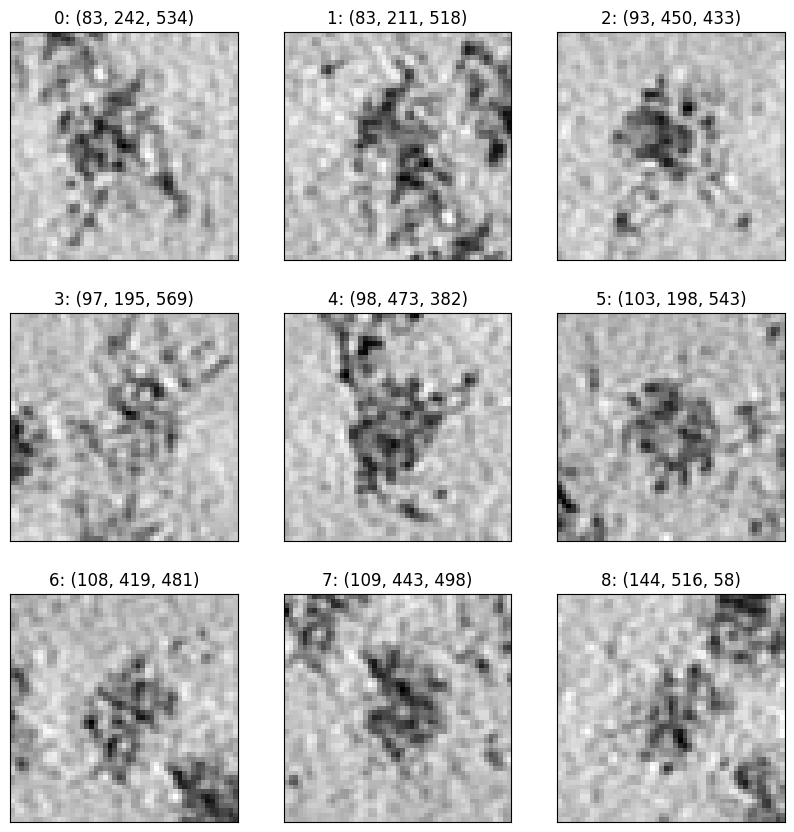

In [68]:
plot_particles('TS_6_6', 'ribosome',n_show=9)

In [28]:
ribosomes_x = []
ribosomes_y = []
f = open('/kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_6_4/Picks/ribosome.json')
for p in json.loads(f.read())['points']:
    z = float(p['location']['z'])
    if z >= 600 and z < 650:
        ribosomes_x.append(float(p['location']['x'])/10)
        ribosomes_y.append(float(p['location']['y'])/10)
        print(p['location'])

{'x': 5274.903, 'y': 5288.121, 'z': 619.798}
{'x': 5312.439, 'y': 4964.156, 'z': 602.574}
{'x': 5130.837, 'y': 5121.036, 'z': 631.702}
{'x': 5106.838, 'y': 4835.263, 'z': 619.225}
{'x': 1273.648, 'y': 4386.703, 'z': 631.656}
{'x': 440.984, 'y': 3866.177, 'z': 643.857}
{'x': 1015.725, 'y': 640.198, 'z': 622.387}


Text(0.5, 0.91, 'Annotated ribosomes in TS_6_4, for 600 < z < 650')

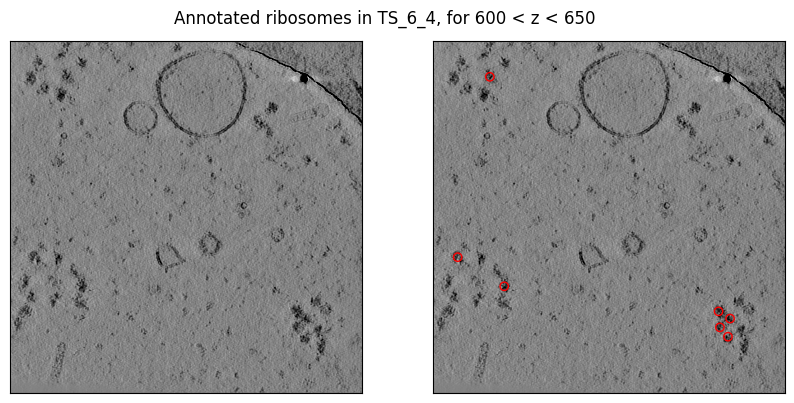

In [29]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(z_ts_6_4[0][62], cmap='gray', vmin=-0.00005, vmax=0.00005)
ax = plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(z_ts_6_4[0][62], cmap='gray', vmin=-0.00005, vmax=0.00005)
plt.scatter(ribosomes_x, ribosomes_y, edgecolor='red', facecolor='none')
plt.suptitle('Annotated ribosomes in TS_6_4, for 600 < z < 650',y=0.91)

## Thyroglobulin

![](https://cdn.rcsb.org/images/structures/6scj_assembly-1.jpeg)

Image from this source:  
[https://www.rcsb.org/structure/6scj](https://www.rcsb.org/structure/6scj)

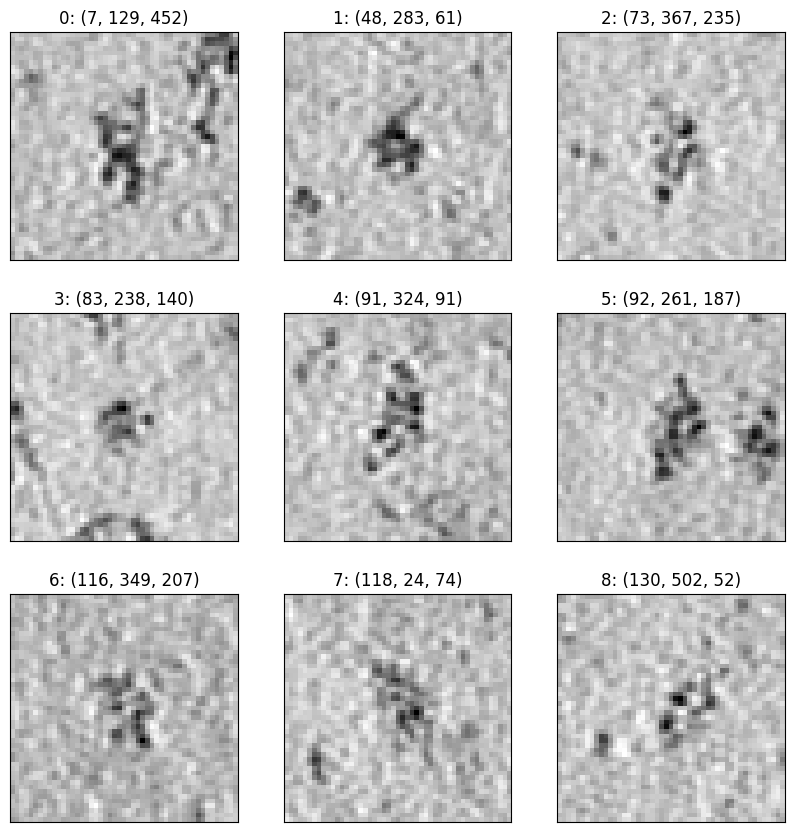

In [69]:
plot_particles('TS_73_6', 'thyroglobulin',n_show=9)

In [65]:
thyroglobulin_x = []
thyroglobulin_y = []
f = open('/kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_6_4/Picks/thyroglobulin.json')
for p in json.loads(f.read())['points']:
    z = float(p['location']['z'])
    if z >= 550 and z < 600:
        thyroglobulin_x.append(float(p['location']['x'])/10)
        thyroglobulin_y.append(float(p['location']['y'])/10)
        print(p['location'])

{'x': 1242.919, 'y': 1464.644, 'z': 581.353}
{'x': 3547.616, 'y': 4770.646, 'z': 595.253}
{'x': 4756.011, 'y': 4447.041, 'z': 581.386}
{'x': 3553.393, 'y': 2129.821, 'z': 561.696}


Text(0.5, 0.91, 'Annotated thyroglobulin in TS_6_4, for 550 < z < 600')

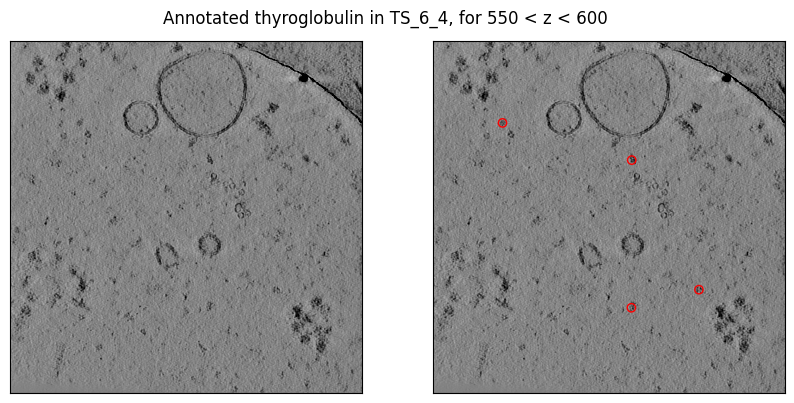

In [66]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(z_ts_6_4[0][57], cmap='gray', vmin=-0.00005, vmax=0.00005)
ax = plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(z_ts_6_4[0][57], cmap='gray', vmin=-0.00005, vmax=0.00005)
plt.scatter(thyroglobulin_x, thyroglobulin_y, edgecolor='red', facecolor='none')
plt.suptitle('Annotated thyroglobulin in TS_6_4, for 550 < z < 600',y=0.91)

## Virus-Like-Particle

![](https://cdn.rcsb.org/images/structures/6n4v_assembly-1.jpeg)

Image from this source:  
[https://www.rcsb.org/structure/6N4V](https://www.rcsb.org/structure/6N4V)

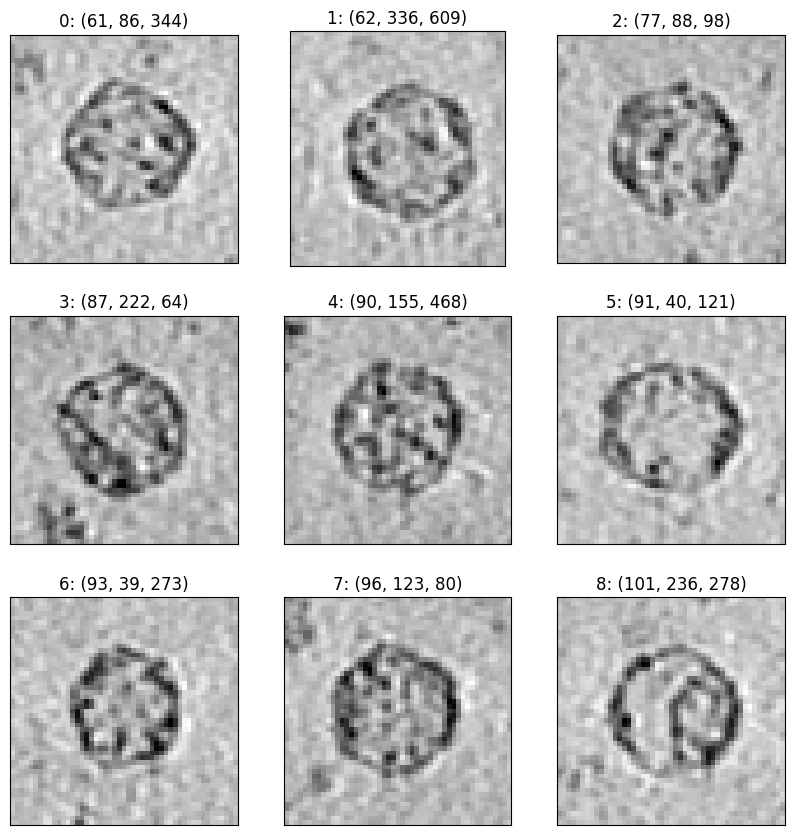

In [70]:
plot_particles('TS_86_3', 'virus-like-particle',n_show=9)

In [43]:
virus_x = []
virus_y = []
f = open('/kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_6_4/Picks/virus-like-particle.json')
for p in json.loads(f.read())['points']:
    z = float(p['location']['z'])
    if z >= 670 and z < 700:
        virus_x.append(float(p['location']['x'])/10)
        virus_y.append(float(p['location']['y'])/10)
        print(p['location'])

{'x': 911.29, 'y': 5638.402, 'z': 671.21}
{'x': 5580.108, 'y': 1240.86, 'z': 692.222}
{'x': 4765.58, 'y': 3469.964, 'z': 689.813}


Text(0.5, 0.91, 'Annotated virus like particles in TS_6_4, for 670 < z < 700')

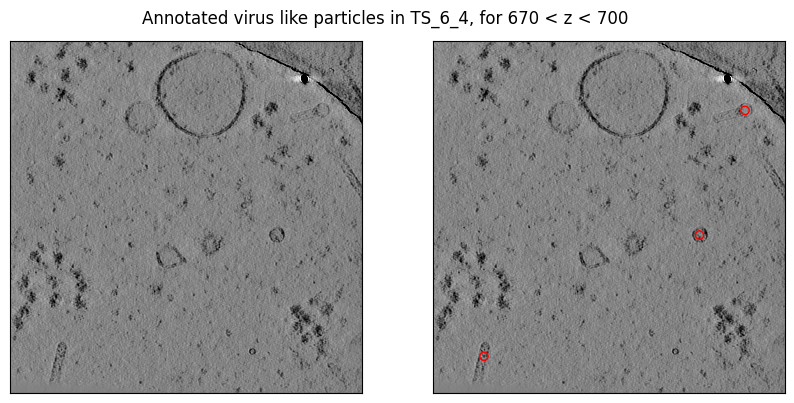

In [47]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(z_ts_6_4[0][68], cmap='gray', vmin=-0.00005, vmax=0.00005)
ax = plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(z_ts_6_4[0][68], cmap='gray', vmin=-0.00005, vmax=0.00005)
plt.scatter(virus_x, virus_y, edgecolor='red', facecolor='none')
plt.suptitle('Annotated virus like particles in TS_6_4, for 670 < z < 700',y=0.91)

# Plot 3D position map for each particle, using an arbitrary experiment

In [39]:
def plot_particles_3d(experiment, particles_to_plot):
    if isinstance(particles_to_plot,str):
        particles_to_plot = [particles_to_plot]
        
    particle_list = []
    for particle in particles_to_plot:
        particle_coords = load_points(experiment, particle=particle)
        for p in particle_coords:
            particle_list.append({'pname':particle, 'x':np.rint(p[0]/10.012),
                                  'y':np.rint(p[1]/10.012), 'z':np.rint(p[2]/10.012), 'size': 1})
        
    fig = px.scatter_3d(particle_list, x='x', y='y', z='z', color='pname', size='size',
                        range_x=[630,0], range_y=[0,630], range_z=[184,0],
                        title=experiment + ': ' + particle,
                        template='seaborn')
    fig.show()

In [42]:
plot_particles_3d('TS_5_4', ['apo-ferritin','beta-amylase','beta-galactosidase','ribosome','thyroglobulin','virus-like-particle'])